In [47]:
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, Input
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
df = pd.read_csv("ds_salaries.csv")

# Outlier
df = df.drop(["salary_currency"], axis=1)

q1 = df["salary_in_usd"].quantile(0.25) # Quartile 1
q3 = df["salary_in_usd"].quantile(0.75) # Quartile 3
iqr = q3-q1 # Inter Quartile Range

low_lim = q1 - 1.5*iqr
hi_lim = q3 + 1.5*iqr


for i in range(len(df["salary_in_usd"])):
    if hi_lim < df["salary_in_usd"][i]:
        df = df.drop([i])


df["salary_in_usd"] = df["salary_in_usd"].apply(lambda x: 0 if int(x) < 75000 else (1 if 75000 < int(x) < 150000 else 2))
df["salary_value"] = df["salary_in_usd"]
df = df.drop(columns="salary_in_usd")

categorical_columns = ['experience_level', 'employment_type', 'job_title', 'company_size']
for col in categorical_columns:
    df[col] = df[col].astype(str)

x = df.drop(columns="salary_value")
y = df["salary_value"].astype('int')



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


def dataframe_to_dataset(features, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    return dataset.shuffle(len(features)).batch(batch_size)

batch_size = 32
train_dataset = dataframe_to_dataset(X_train, y_train, batch_size)
test_dataset = dataframe_to_dataset(X_test, y_test, batch_size)

In [49]:
input_work_year = Input(shape=(1,), name="work_year")

from tensorflow.keras.layers import StringLookup, CategoryEncoding

# Vocabulary lookup
input_experience = tf.keras.layers.Input(shape=(1,), name="experience_level", dtype=tf.string)
vocab_layer = StringLookup(vocabulary=["EN", "MI", "SE", "EX"], output_mode="int")
one_hot_layer = CategoryEncoding(num_tokens=vocab_layer.vocabulary_size())

experience_encoded = one_hot_layer(vocab_layer(input_experience))

from tensorflow.keras.layers import Concatenate

merged_features = Concatenate()([input_work_year, experience_encoded])

from tensorflow.keras import Model

from tensorflow.keras.layers import Dense

x = Dense(64, activation="relu")(merged_features)
x = Dense(32, activation="relu")(x)
output = Dense(3, activation="softmax")(x)

model = Model(inputs=[input_work_year, input_experience], outputs=output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Evaluasi pada data test
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3240 - loss: 89.7332  
Test Loss: 90.1571
Test Accuracy: 0.3333


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


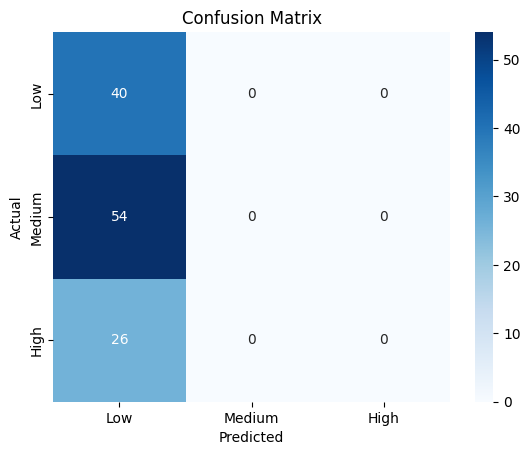

In [50]:
y_pred_probs = model.predict(test_dataset)  
y_pred = np.argmax(y_pred_probs, axis=1)
np.argmax(y_pred_probs, axis=1)

y_true = np.concatenate([y for x, y in test_dataset], axis=0)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [51]:
print(classification_report(y_true, y_pred, target_names=['Low', 'Medium', 'High']))

              precision    recall  f1-score   support

         Low       0.33      1.00      0.50        40
      Medium       0.00      0.00      0.00        54
        High       0.00      0.00      0.00        26

    accuracy                           0.33       120
   macro avg       0.11      0.33      0.17       120
weighted avg       0.11      0.33      0.17       120



c:\Users\Nur Hary\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nur Hary\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nur Hary\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4179 - loss: 95.8456 - val_accuracy: 0.3115 - val_loss: 25.1492
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3140 - loss: 15.8842 - val_accuracy: 0.1803 - val_loss: 2.8793
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2631 - loss: 3.3551 - val_accuracy: 0.4590 - val_loss: 1.2531
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4243 - loss: 1.4548 - val_accuracy: 0.5082 - val_loss: 1.3263
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3569 - loss: 1.2868 - val_accuracy: 0.3115 - val_loss: 1.1359
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3850 - loss: 1.1296 - val_accuracy: 0.3197 - val_loss: 1.1677
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3403 - loss: 1.2543 - val_accuracy: 0.3115 - val_loss: 2.2886
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3719 - loss: 1.8352 - val_accuracy: 0.5082 - val_l

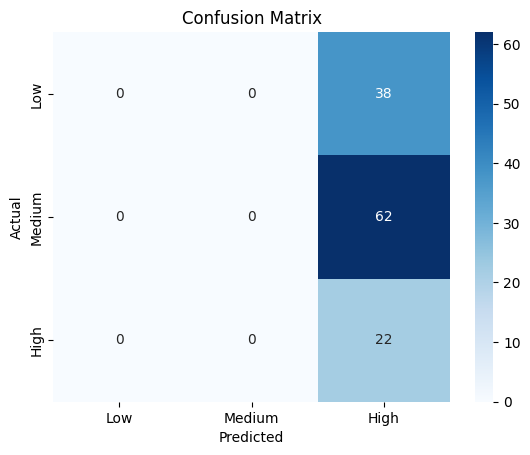

              precision    recall  f1-score   support

         Low       0.00      0.00      0.00        38
      Medium       0.00      0.00      0.00        62
        High       0.18      1.00      0.31        22

    accuracy                           0.18       122
   macro avg       0.06      0.33      0.10       122
weighted avg       0.03      0.18      0.06       122



c:\Users\Nur Hary\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nur Hary\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Nur Hary\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

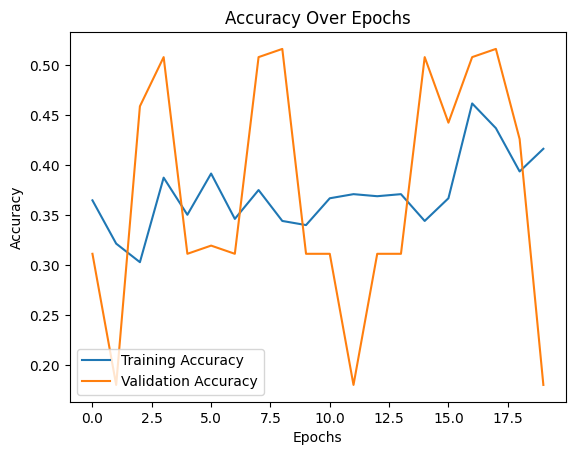

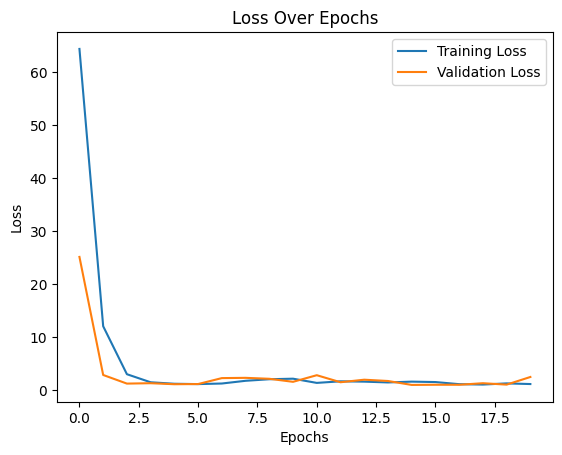

In [54]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Load Dataset
df = pd.read_csv("ds_salaries.csv")

# Pilih kolom yang relevan
columns = ['work_year', 'experience_level', 'employment_type', 'job_title', 'salary_in_usd', 'company_size']
df = df[columns]

# Klasifikasikan salary menjadi kategori
bins = [0, 75000, 150000, float('inf')]
labels = [0, 1, 2]  # Low=0, Medium=1, High=2
df['salary_category'] = pd.cut(df['salary_in_usd'], bins=bins, labels=labels)

# Hapus kolom salary_in_usd
df.drop('salary_in_usd', axis=1, inplace=True)

# Konversi kategori menjadi string untuk TensorFlow
categorical_columns = ['experience_level', 'employment_type', 'job_title', 'company_size']
for col in categorical_columns:
    df[col] = df[col].astype(str)

# Pisahkan fitur dan label
X = df.drop('salary_category', axis=1)
y = df['salary_category'].astype('int')

# Split dataset menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Konversi data ke dataset TensorFlow
def dataframe_to_dataset(features, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    return dataset.shuffle(len(features)).batch(batch_size)

batch_size = 32
train_dataset = dataframe_to_dataset(X_train, y_train, batch_size)
test_dataset = dataframe_to_dataset(X_test, y_test, batch_size)

# 2. Buat Fitur TensorFlow
from tensorflow.keras.layers import StringLookup, CategoryEncoding, Dense, Concatenate

# Fitur numerik
numerical_input = tf.keras.layers.Input(shape=(1,), name='work_year')

# Fitur kategorikal dengan one-hot encoding
categorical_inputs = {}
categorical_encodings = []

for col in categorical_columns:
    input_layer = tf.keras.layers.Input(shape=(1,), name=col, dtype=tf.string)
    categorical_inputs[col] = input_layer
    vocab = X[col].unique()
    lookup_layer = StringLookup(vocabulary=list(vocab), output_mode='int')(input_layer)
    one_hot_layer = CategoryEncoding(num_tokens=len(vocab))(lookup_layer)
    categorical_encodings.append(one_hot_layer)

# Gabungkan semua fitur
all_features = [numerical_input] + categorical_encodings
merged_features = Concatenate()(all_features)

# 3. Bangun Model
x = Dense(64, activation='relu')(merged_features)
x = Dense(32, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

inputs = [numerical_input] + list(categorical_inputs.values())
model = tf.keras.Model(inputs=inputs, outputs=output)

# Kompilasi model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 4. Latih Model
history = model.fit(train_dataset, validation_data=test_dataset, epochs=20)

# 5. Evaluasi Model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 6. Confusion Matrix dan Classification Report
# Ambil prediksi
y_pred_probs = model.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for _, y in test_dataset], axis=0)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=['Low', 'Medium', 'High']))

# 7. Visualisasi Akurasi dan Loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()
